In [ ]:
import zipfile
with zipfile.ZipFile('/content/FruitinAmazon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')

In [ ]:
train_dir = '/content/drive/MyDrive/FruitinAmazon/train'
test_dir = '/content/drive/MyDrive/FruitinAmazon/test'

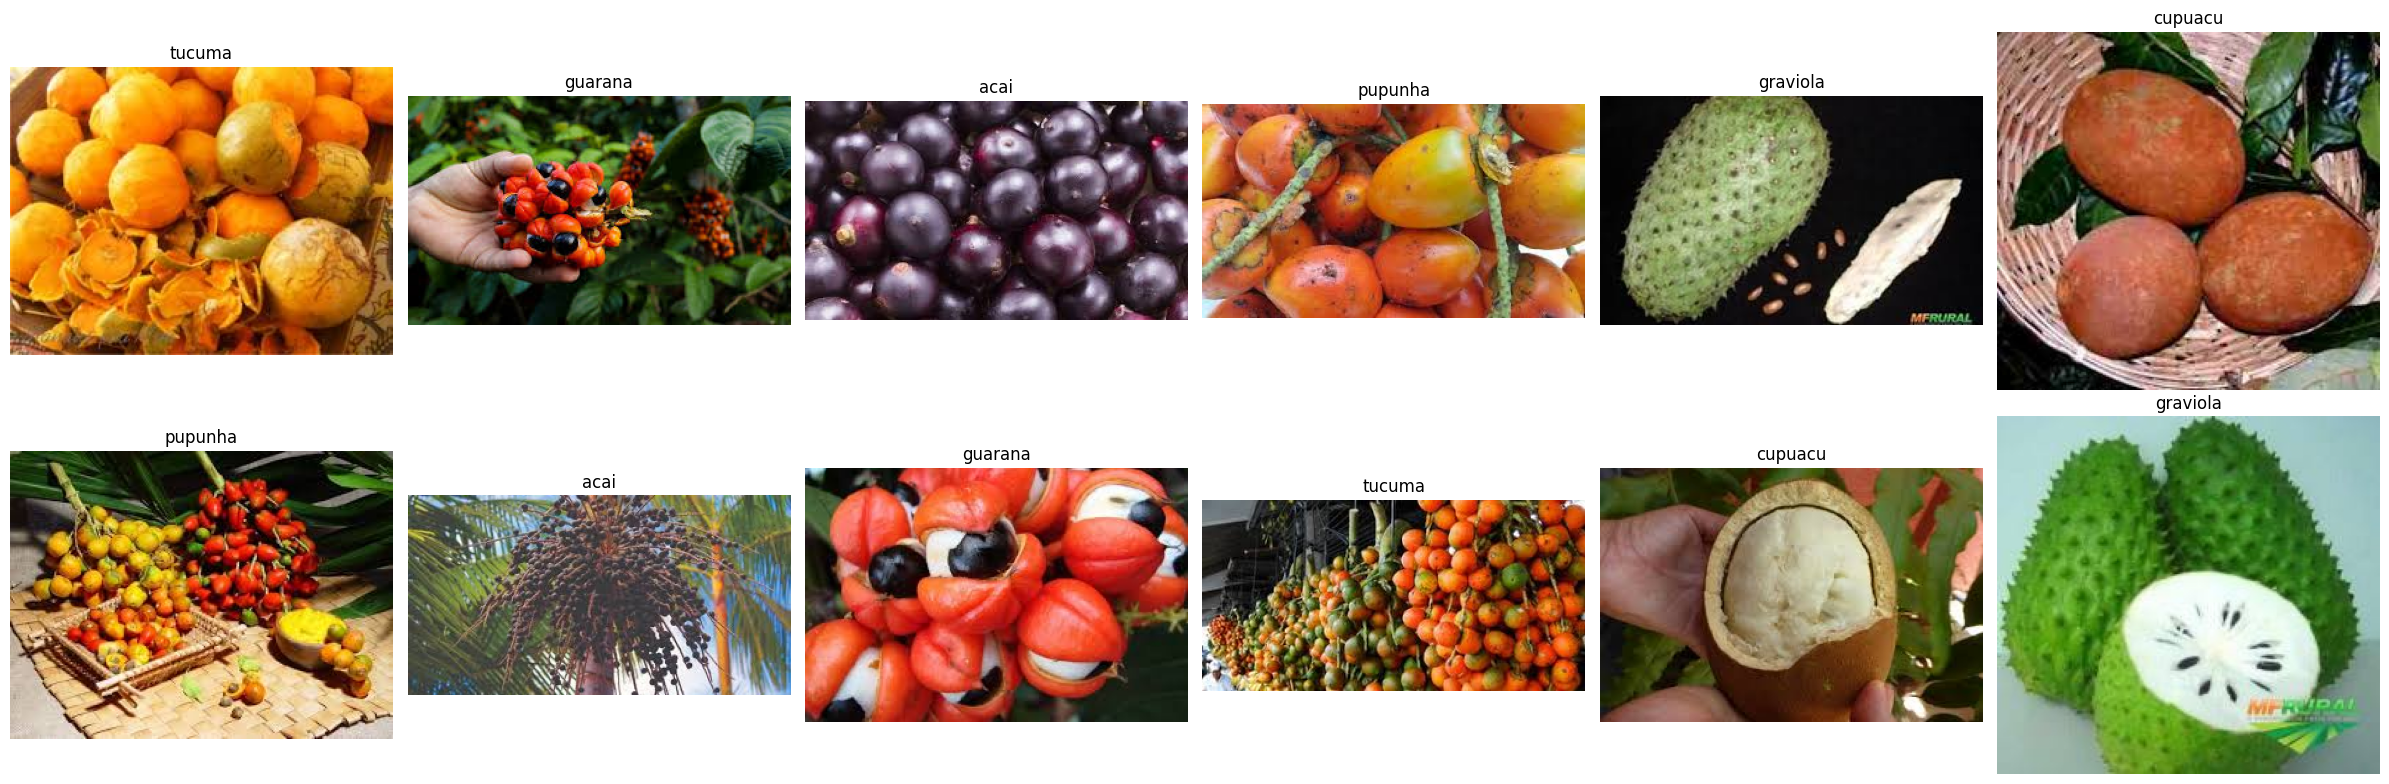

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Get the list of class directories
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Shuffle class list for display variety
random.shuffle(classes)

# Select one random image from each class
sample_images = []
sample_labels = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if image_files:
        img_file = random.choice(image_files)
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert('RGB')
        images.append(img)
        labels.append(class_name)

# Plotting - display in grid with 2 rows
num_images = len(images)
num_cols = (num_images + 1) // 2

plt.figure(figsize=(4 * num_cols, 8))  # Adjust figure size if needed

for i, img in enumerate(images):
    plt.subplot(2, num_cols, i + 1)
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image, UnidentifiedImageError

# List to store corrupted image paths
corrupted_images = []

# Loop through each class subdirectory
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        try:
            with Image.open(img_path) as img:
                img.verify()  # Verify that it's a valid image
        except (IOError, SyntaxError, UnidentifiedImageError):
            corrupted_images.append(img_path)
            os.remove(img_path)
            print(f"Removed corrupted image: {img_path}")

# Final output
if not corrupted_images:
    print("No corrupted images found.")


No corrupted images found.


In [ ]:
import tensorflow as tf
import os

# Define constants
img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2
seed = 123

# Normalization layer
rescale = tf.keras.layers.Rescaling(1./255)

# Load and preprocess training dataset
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
     subset='training',
    seed=seed
)
# Extract class names before mapping
class_names = raw_train_ds.class_names
num_classes = len(class_names)

# Normalize dataset
train_ds = raw_train_ds.map(lambda x, y: (rescale(x), y))

# Load and preprocess validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=seed
)
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

# Define CNN + Fully Connected architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Setup directory to save best model
checkpoint_path = "best_model.h5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

# Optional: Load best model after training
model.load_weights(checkpoint_path)

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.1846 - loss: 2.0964
Epoch 1: val_loss improved from inf to 1.80810, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 627ms/step - accuracy: 0.1871 - loss: 2.1225 - val_accuracy: 0.0000e+00 - val_loss: 1.8081
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.1748 - loss: 2.0212
Epoch 2: val_loss did not improve from 1.80810
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 441ms/step - accuracy: 0.1762 - loss: 2.0027 - val_accuracy: 0.0000e+00 - val_loss: 1.8271
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.2037 - loss: 1.7321
Epoch 3: val_loss did not improve from 1.80810
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 463ms/step - accuracy: 0.2118 - loss: 1.7296 - val_accuracy: 0.0000e+00 - val_loss: 1.8565
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.1742 - loss: 1.6891
Epoch 4: val_loss did not improve from 1.80810
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 614ms/step - accuracy: 0.1793 - loss: 1.6893 - val_accuracy: 0.0000e+00 - val_loss: 1.9634
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.1944 - loss: 1.6400
Epoch 5: val_loss improved from 1.80810 to 1.69

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 498ms/step - accuracy: 0.1979 - loss: 1.6399 - val_accuracy: 0.4444 - val_loss: 1.6985
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.3142 - loss: 1.5802
Epoch 6: val_loss improved from 1.69847 to 1.55790, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.3190 - loss: 1.5719 - val_accuracy: 0.6667 - val_loss: 1.5579
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.4340 - loss: 1.4330
Epoch 7: val_loss improved from 1.55790 to 1.53541, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 504ms/step - accuracy: 0.4401 - loss: 1.4367 - val_accuracy: 0.5000 - val_loss: 1.5354
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.5700 - loss: 1.2991
Epoch 8: val_loss did not improve from 1.53541
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 450ms/step - accuracy: 0.5699 - loss: 1.2959 - val_accuracy: 0.2778 - val_loss: 1.6539
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.6921 - loss: 1.0798
Epoch 9: val_loss improved from 1.53541 to 1.16469, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.6788 - loss: 1.0853 - val_accuracy: 0.7222 - val_loss: 1.1647
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.8409 - loss: 0.8628
Epoch 10: val_loss improved from 1.16469 to 0.93877, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 861ms/step - accuracy: 0.8355 - loss: 0.8633 - val_accuracy: 0.6111 - val_loss: 0.9388
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7743 - loss: 0.8017
Epoch 11: val_loss did not improve from 0.93877
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.7786 - loss: 0.7893 - val_accuracy: 0.6667 - val_loss: 1.1137
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.8762 - loss: 0.5593
Epoch 12: val_loss improved from 0.93877 to 0.81709, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.8689 - loss: 0.5599 - val_accuracy: 0.7778 - val_loss: 0.8171
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.9398 - loss: 0.4354
Epoch 13: val_loss improved from 0.81709 to 0.66446, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.9410 - loss: 0.4297 - val_accuracy: 0.7222 - val_loss: 0.6645
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9294 - loss: 0.3428
Epoch 14: val_loss improved from 0.66446 to 0.50354, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.9332 - loss: 0.3334 - val_accuracy: 0.8333 - val_loss: 0.5035
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9699 - loss: 0.2084
Epoch 15: val_loss improved from 0.50354 to 0.48420, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step - accuracy: 0.9705 - loss: 0.2058 - val_accuracy: 0.8333 - val_loss: 0.4842
Epoch 16/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9803 - loss: 0.1782
Epoch 16: val_loss improved from 0.48420 to 0.40515, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - accuracy: 0.9783 - loss: 0.1787 - val_accuracy: 0.8333 - val_loss: 0.4052
Epoch 17/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9803 - loss: 0.1356
Epoch 17: val_loss did not improve from 0.40515
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 747ms/step - accuracy: 0.9783 - loss: 0.1386 - val_accuracy: 0.7222 - val_loss: 0.9328
Epoch 18/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 1.0000 - loss: 0.0922
Epoch 18: val_loss did not improve from 0.40515
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 448ms/step - accuracy: 1.0000 - loss: 0.0911 - val_accuracy: 0.8333 - val_loss: 0.6090
Epoch 19/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9902 - loss: 0.0915
Epoch 19: val_loss did not improve from 0.40515
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.9891 - loss: 0.0914 - val_accuracy: 0.8333 - val_loss: 0.4191
Epoch 20/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9601 - loss: 0.0845
Epoch 20: val_loss did not improve from 0.40515
3/3 ━━━━

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Evaluate model on the test set (you must load test data similar to train/val)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    seed=123
)
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Model Evaluation
loss, accuracy = model.evaluate(test_ds)
print(f"\n Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
# Save model
model.save("fruit_classifier_model.h5")
print("\nModel saved to fruit_classifier_model.h5")

# Load the model back
loaded_model = tf.keras.models.load_model("fruit_classifier_model.h5")
print("Model loaded from disk.")

# Re-evaluate loaded model
loss, accuracy = loaded_model.evaluate(test_ds)
print(f"\nLoaded Model Test Loss: {loss:.4f}")
print(f"Loaded Model Test Accuracy: {accuracy:.4f}")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.5667 - loss: 1.4046



 Test Loss: 1.4046
Test Accuracy: 0.5667

Model saved to fruit_classifier_model.h5


Model loaded from disk.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 518ms/step - accuracy: 0.5667 - loss: 1.4046

Loaded Model Test Loss: 1.4046
Loaded Model Test Accuracy: 0.5667


In [ ]:
y_pred_probs = loaded_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = []
for _, labels in test_ds.unbatch():
    y_true.append(labels.numpy())
y_true = np.array(y_true)

# Classification Report
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step

 Classification Report:
              precision    recall  f1-score   support

        acai       1.00      0.60      0.75         5
     cupuacu       0.67      0.40      0.50         5
    graviola       0.42      1.00      0.59         5
     guarana       1.00      0.40      0.57         5
     pupunha       0.56      1.00      0.71         5
      tucuma       0.00      0.00      0.00         5

    accuracy                           0.57        30
   macro avg       0.61      0.57      0.52        30
weighted avg       0.61      0.57      0.52        30

